# Perception.py test
- for more accurate result, OTSU theory can be used. but use static parameter here in order to balance the accurate & program speed
- added rock_thresh() for image rock thresholding

In [1]:
%matplotlib inline

import numpy as np
import cv2


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc
import time

In [2]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
#OTSU thresholding function
def otsu_threshold(im):
    pixel_counts = [np.sum(im == i) for i in range(256)]
    s_max = (0,-1)
    ss = []
    for threshold in range(256):
        w_0 = sum(pixel_counts[:threshold]) #  pixels below the threshold
        w_1 = sum(pixel_counts[threshold:]) 
        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)]) / w_0 if w_0 > 0 else 0
        # pixels average value below the threshold
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)]) / w_1 if w_1 > 0 else 0
        # formula
        s = 1.0 * w_0 * w_1 * (mu_0 - mu_1) ** 2
        # Integer overflow if use w_0 * w_1 directly, then * 1.0 to float
        ss.append(s)
        # get the max value
        if s > s_max[1]:
            s_max = (threshold, s)
    return s_max[0]


def color_thresh(img): 
    #otsu_red = otsu_threshold((img[:,:,0]))
    #otsu_green = otsu_threshold((img[:,:,1]))
    #otsu_blue = otsu_threshold((img[:,:,2]))
    otsu_red = 160
    otsu_green = 160
    otsu_blue = 160
    #print(otsu_red,otsu_green,otsu_blue)
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > otsu_red) \
                & (img[:,:,1] > otsu_green) \
                & (img[:,:,2] > otsu_blue)
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    #print(str(color_select))
    # Return the binary image
    return color_select

# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Apply the above functions in succession and update the Rover state accordingly
def perception_step(Rover):
    # Perform perception steps to update Rover()
    # TODO: 
    # NOTE: camera image is coming to you in Rover.img
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Update Rover.vision_image (this will be displayed on left side of screen)
        # Example: Rover.vision_image[:,:,0] = obstacle color-thresholded binary image
        #          Rover.vision_image[:,:,1] = rock_sample color-thresholded binary image
        #          Rover.vision_image[:,:,2] = navigable terrain color-thresholded binary image

    # 5) Convert map image pixel values to rover-centric coords
    # 6) Convert rover-centric pixel values to world coordinates
    # 7) Update Rover worldmap (to be displayed on right side of screen)
        # Example: Rover.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          Rover.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          Rover.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    # 8) Convert rover-centric pixel positions to polar coordinates
    # Update Rover pixel distances and angles
        # Rover.nav_dists = rover_centric_pixel_distances
        # Rover.nav_angles = rover_centric_angles
    
 
    
    
    return Rover

## Define source and DST

In [3]:
example_rock = '../calibration_images/example_rock1.jpg'
rock_img = mpimg.imread(example_rock)

hsv_lower_yellow = np.array([93, 173, 131])
hsv_upper_yellow = np.array([98, 255, 182])
def rock_thresh(wp_img):
    hsv = cv2.cvtColor(wp_img, cv2.COLOR_BGR2HSV)
    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, hsv_lower_yellow, hsv_upper_yellow)
    #bitwise-AND: overlay the mask image and original image
    res = cv2.bitwise_and(wp_img, wp_img, mask = mask)
    return mask, res

dst_size = 5 
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[rock_img.shape[1]/2 - dst_size, rock_img.shape[0] - bottom_offset],
                      [rock_img.shape[1]/2 + dst_size, rock_img.shape[0] - bottom_offset],
                      [rock_img.shape[1]/2 + dst_size, rock_img.shape[0] - 2*dst_size - bottom_offset], 
                      [rock_img.shape[1]/2 - dst_size, rock_img.shape[0] - 2*dst_size - bottom_offset],
                      ])

## Apply perspective transform

In [4]:
wponly_img = perspect_transform(rock_img,source,destination) 

## Apply color threshold to identify navigable terrain/obstacles/rock samples

Warped Threshed Navigation : uint8 (160, 320) 0 1
Warped Threshed Obstacle : uint8 (160, 320) 0 1
Warped Threshed Rock Mask Value : uint8 (160, 320) 0 1


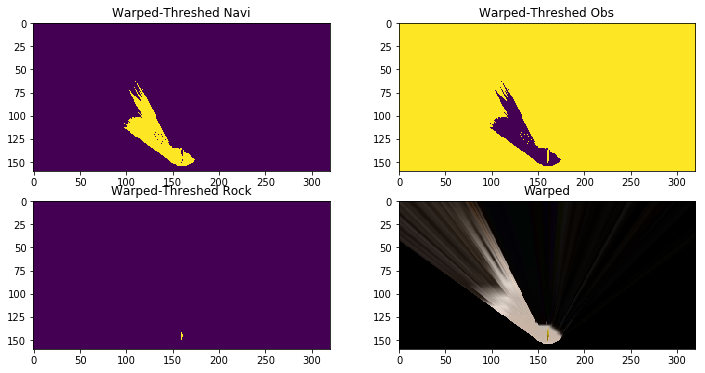

In [5]:
#the rock lower and upper value is find from Slack Discussion, but should find the good way later
wp_th_imgNavi = color_thresh(wponly_img)
wp_th_imgObs = 1-wp_th_imgNavi
    #wp_th_imgObs = ~wp_th_imgNavi
wp_th_imgRock_mask, wp_th_imgRock_res = (rock_thresh(wponly_img))
wp_th_imgRock_mask = (wp_th_imgRock_mask/255).astype(np.uint8)

print('Warped Threshed Navigation : '+str(wp_th_imgNavi.dtype), wp_th_imgNavi.shape, np.min(wp_th_imgNavi), np.max(wp_th_imgNavi))
print('Warped Threshed Obstacle : '+str(wp_th_imgObs.dtype), wp_th_imgObs.shape, np.min(wp_th_imgObs), np.max(wp_th_imgObs))
print('Warped Threshed Rock Mask Value : '+str(wp_th_imgRock_mask.dtype), wp_th_imgRock_mask.shape, np.min(wp_th_imgRock_mask), np.max(wp_th_imgRock_mask))

fig = plt.figure(figsize=(12,6))
plt.subplot(221)
plt.title('Warped-Threshed Navi')
plt.imshow(wp_th_imgNavi+wp_th_imgRock_mask)
plt.subplot(222)
plt.title('Warped-Threshed Obs')
plt.imshow(wp_th_imgObs)
plt.subplot(223)
plt.title('Warped-Threshed Rock')
plt.imshow(wp_th_imgRock_mask)
plt.subplot(224)
plt.title('Warped')
plt.imshow(wponly_img)

## Update Rover.vision_image (this will be displayed on left side of screen)

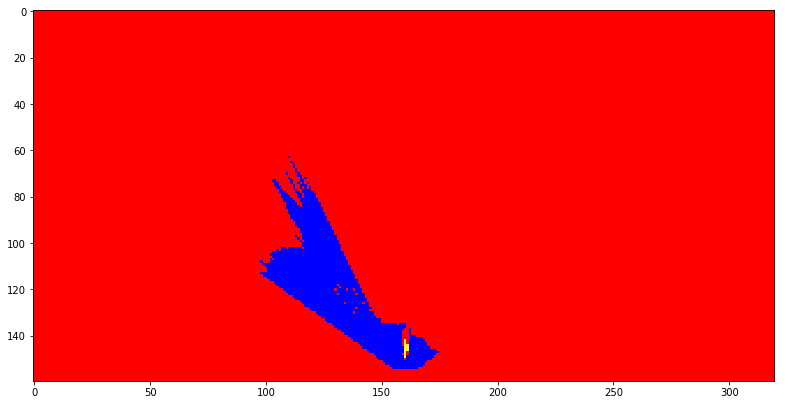

In [6]:
r_v_img = np.zeros((rock_img.shape[0],rock_img.shape[1],3)).astype(np.uint8)

y_navi, x_navi = wp_th_imgNavi.nonzero()
y_obs, x_obs = wp_th_imgObs.nonzero()
y_rock, x_rock = wp_th_imgRock_mask.nonzero()

r_v_img[:,:,0] =  wp_th_imgObs
r_v_img[:,:,1] = wp_th_imgRock_mask
r_v_img[:,:,2] = wp_th_imgNavi

fig = plt.figure(figsize=(30,15))
plt.title('Overlay dif color')
plt.subplot(221)
plt.imshow(r_v_img*255)


## Convert map image pixel values to rover-centric coords

OBS pixels= 16
Navi pixels= 144


(0, 160)

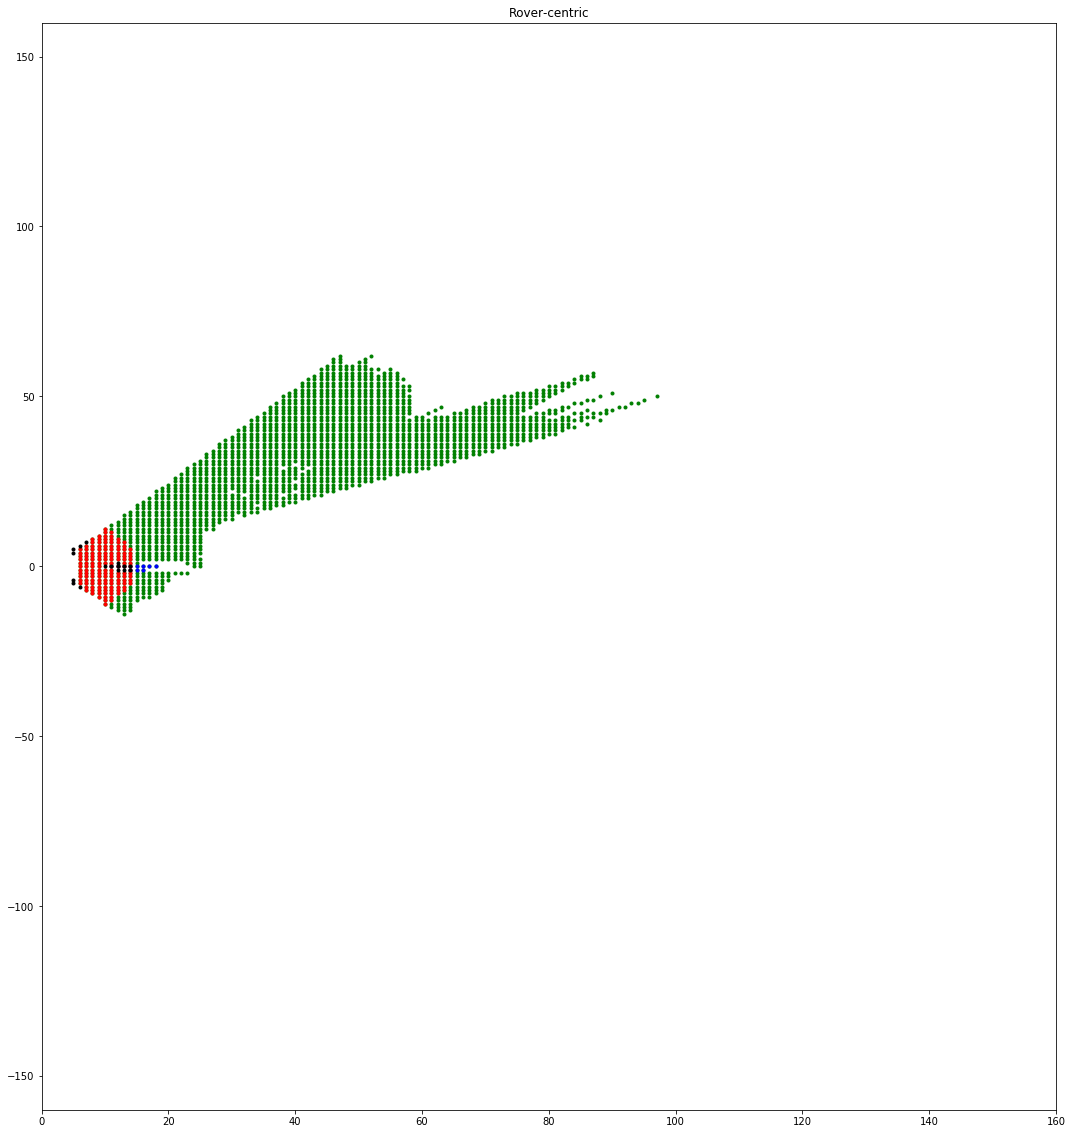

In [7]:
x_obs_rc, y_obs_rc = rover_coords(wp_th_imgObs)
x_rock_rc, y_rock_rc = rover_coords(wp_th_imgRock_mask)
x_navi_rc, y_navi_rc = rover_coords(wp_th_imgNavi+wp_th_imgRock_mask)

#dist_1, angel_1 = to_polar_coords(x_navi_rc, y_navi_rc)
#print('max navi_angel='+str(np.amax(angel_1)* 180/np.pi))
#print('Min navi_agle='+ str(np.amin(angel_1)* 180/np.pi))
#d, a = to_polar_coords(x_navi_rc, y_navi_rc)
#print('Polar angel = '+str(a))
#print(np.clip(np.mean(a * 180/np.pi), -15, 15))

X_ymin =x_navi_rc[y_navi_rc == np.amin(y_navi_rc)]
Ymin = np.zeros(len(X_ymin)) + np.amin(y_navi_rc)
#b = to_polar_coords(X_ymin, Ymin)[1]
#print('Ymin= ' + str(Ymin))
#print('X_ymin= '+str(X_ymin))
#print(b)
#print(np.clip(np.mean(b * 180/np.pi), -15, 0))
#def radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc) :

def radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc) :
    
    dist_navi,angle_navi = to_polar_coords(x_navi_rc,y_navi_rc)
    dist_navi_front = dist_navi[(6 <= dist_navi) & (dist_navi < 15)]
    angle_navi_front = angle_navi[(6 <= dist_navi) & (dist_navi < 15)]
    
    dist_obs,angle_obs = to_polar_coords(x_obs_rc,y_obs_rc)
    dist_obs_front = dist_obs[(6 <= dist_obs) & (dist_obs < 15)]
    angle_obs_front = angle_obs[(6 <= dist_obs) & (dist_obs < 15)]
    
    angle_obs_in_navi = np.copy(angle_obs_front)
    dist_obs_in_navi = np.copy(dist_obs_front)
    angle_navi_shrink = np.copy(angle_navi_front)
    dist_navi_shrink = np.copy(dist_navi_front)
    if len(angle_navi_front) > 0 :
        angle_obs_in_navi = angle_obs_front[(angle_obs_front <= np.amax(angle_navi_front)) & (angle_obs_front >=np.amin(angle_navi_front))]
        dist_obs_in_navi = dist_obs_front[(angle_obs_front <= np.amax(angle_navi_front)) & (angle_obs_front >=np.amin(angle_navi_front))]
        
    return dist_navi_shrink,angle_navi_shrink,dist_obs_in_navi,angle_obs_in_navi
    
print('OBS pixels= '+str(len(radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)[2])))
print('Navi pixels= '+str(len(radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)[0])))
#print('Navi mean angle = '+ str(np.mean(radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)[1]* 180/np.pi)))
#print('OBS mean angle= '+str(np.mean(radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)[3]* 180/np.pi)))

navix_front =  radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)[0]*np.cos(radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)[1])
naviy_front = radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)[0]*np.sin(radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)[1])
obsx_front = radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)[2]*np.cos(radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)[3])
obsy_front = radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)[2]*np.sin(radar_scan(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)[3])


#print('Navi & Obs radial coords ARRAY within 2 meter: '+str(radar_scan_2m(x_navi_rc,y_navi_rc,x_obs_rc,y_obs_rc)))    
            
#print(angel_obs_in_navi* 180/np.pi,dist_obs_in_navi)
# print(np.amax(angel_navi_front)* 180/np.pi,np.amin(angel_navi_front)* 180/np.pi)    
#    print('Counter barrier'+str(counter)+' = '+ str(dist_obs_front[angel_obs_front ==angel_navi_front[counter]]))           


#print('OBS 4 m to polar angel'+str(angel_obs_4m))

#
fig = plt.figure(figsize=(40,20))
plt.subplot(121)
plt.plot(x_obs_rc,y_obs_rc, 'w.', x_navi_rc, y_navi_rc, 'g.',x_rock_rc,y_rock_rc, 'b.',navix_front, naviy_front,'r.',obsx_front,obsy_front,'k.')
plt.title('Rover-centric')

#plt.ylim(-160, 160)
plt.ylim(- rock_img.shape[1]/2,  rock_img.shape[1]/2)
plt.xlim(0, rock_img.shape[0])

## Convert rover-centric pixel values to world coordinates

Ground truth : float32 (200, 200) 0.0 1.0
Ground truth 3D : float64 (200, 200, 3) 0.0 255.0
map_add : float64 (200, 200, 3) 0.0 127.5


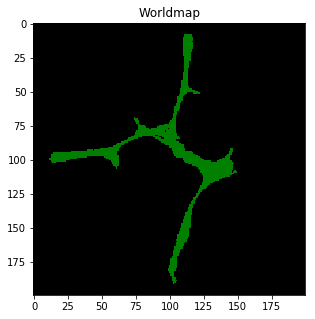

In [8]:

ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

#RGB(0,255,0) = lime color
worldmap = np.zeros((200, 200, 3)).astype(np.float)
map_add = cv2.addWeighted(worldmap, 1, ground_truth_3d, 0.5, 0)
print('Ground truth : '+str(ground_truth.dtype), ground_truth.shape, np.min(ground_truth), np.max(ground_truth))
print('Ground truth 3D : '+str(ground_truth_3d.dtype), ground_truth_3d.shape, np.min(ground_truth_3d), np.max(ground_truth_3d))
print('map_add : '+str(map_add.dtype), map_add.shape, np.min(map_add), np.max(map_add))


fig = plt.figure(figsize=(12,5))
plt.title('Worldmap')
plt.imshow(map_add.astype(np.uint8))
scipy.misc.imsave('../output/map_add.jpg', map_add)

## Update Rover worldmap (to be displayed on right side of screen)

map_add : float64 (200, 200, 3) 0.0 255.0


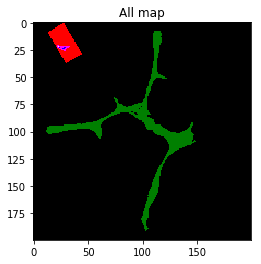

In [9]:
worldmap =  np.zeros((200, 200, 3), dtype=np.float)

rover_yaw = np.random.random(1)*360
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

x_navi_world, y_navi_world = pix_to_world(x_navi_rc, y_navi_rc, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                200, 10)
x_obs_world, y_obs_world = pix_to_world(x_obs_rc, y_obs_rc, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                200, 10)
x_rock_world, y_rock_world = pix_to_world(x_rock_rc, y_rock_rc, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                200, 10)

worldmap[y_obs_world, x_obs_world, 0] += 1
worldmap[y_rock_world, x_rock_world, 1] += 1
worldmap[y_navi_world, x_navi_world, 2] += 1

map_add = cv2.addWeighted(worldmap*255, 1, ground_truth_3d, 0.5, 0)

print('map_add : '+str(map_add.dtype), map_add.shape, np.min(map_add), np.max(map_add))

plt.title('All map')
plt.imshow((map_add).astype(np.uint8))
scipy.misc.imsave('../output/all_map.jpg', map_add)

## Convert rover-centric pixel positions to polar coordinates

In [10]:
# Update Rover pixel distances and angles
# Rover.nav_dists = rover_centric_pixel_distances
# Rover.nav_angles = rover_centric_angles


In [11]:

rc_dist, rc_angles = to_polar_coords(x_navi_rc, y_navi_rc)
rc_avg_angle_real = np.mean(rc_angles * 180/np.pi)
rc_avg_angle_clip = np.clip(np.mean(rc_angles * 180/np.pi), -15, 15)

sort_rc_angles = np.sort(np.copy(rc_angles))
sort_rc_dist = np.sort(np.copy(rc_dist))
angle_len =  len(rc_angles[rc_angles < 0])
#print('Rover.steer before clip = '+ str(rc_avg_angle_real))
#print('Rover.steer after clip = '+ str(rc_avg_angle_clip))
#print('all angles = ' + str(sort_rc_angles* 180/np.pi))
#print('all dist = ' + str(sort_rc_dist))
print('The min angles = '+str(np.amin(sort_rc_angles* 180/np.pi)))
print('The max angles = '+str(np.amax(sort_rc_angles* 180/np.pi)))
print('the navi area pixels dist < 2 are:  '+str(rc_dist[rc_dist<=7]))
print('angels with 8 = '+str(rc_angles[rc_dist<=7]* 180/np.pi))
print(np.any((sort_rc_angles* 180/np.pi) <= rc_avg_angle_real) & np.any((sort_rc_angles* 180/np.pi) > rc_avg_angle_real) & np.any(rc_dist))



The min angles = -47.7263109939
The max angles = 52.9801137452
the navi area pixels dist < 2 are:  [ 7.          6.70820393  6.32455532  6.08276253  6.          6.08276253
  6.32455532  6.70820393]
angels with 8 = [ -0.          26.56505118  18.43494882   9.46232221  -0.          -9.46232221
 -18.43494882 -26.56505118]
True


In [12]:
test_nb = np.int_(-15-np.random.random(1)*5)
print(str(test_nb))

[-18]


In [13]:
s_time = time.time()

 

In [14]:
a = np.array([2,3])
b =np.array([8, 10])

y_dist = np.square(abs(a[0]-b[0]))
x_dist = np.square(abs(a[1]-b[1]))


print(np.sqrt(np.sum(np.square(abs(a-b)))))

9.21954445729


In [15]:
# CDF should always be positive
cdf = np.array([[0, 10, 0.01],[1, 2, 0.5]])

print(np.any((0<= cdf) & (cdf <=1)))



True


In [16]:
arr = np.array([[ 1,  2,  3,  4],[ 5,  6,  7,  8],[ 9, 10, 11, 12]])
print(len(arr))
print(np.delete(arr, 1, 0))

3
[[ 1  2  3  4]
 [ 9 10 11 12]]
